In [2]:
from google.colab import files
import pandas as pd
import io

uploaded = files.upload()

Saving time_series_AB 20230111.csv to time_series_AB 20230111.csv
Saving metadata_1.11.23.csv to metadata_1.11.23.csv


In [3]:
import matplotlib.pyplot as plt

metadata = pd.read_csv(io.BytesIO(uploaded['metadata_1.11.23.csv']))
time_series = pd.read_csv(io.BytesIO(uploaded['time_series_AB 20230111.csv']))
time_series = time_series.loc[time_series['Inventory Status'] != 'OOS or Low Inventory']
time_data = time_series[["week_start", "unit_sold", "asin","sales"]]
time_data.head()

,week_start,unit_sold,asin,sales
2,3/11/2018,17,1788381742,172.82
3,3/18/2018,21,1788381742,209.79
4,3/25/2018,40,1788381742,410.18
5,4/1/2018,43,1788381742,429.57
6,4/8/2018,67,1788381742,675.92


In [4]:
# ID and Year Enumeration
asin_list = time_series['asin'].tolist()
unique_ids = [*set(asin_list)]
year_enum = {0: "2014", 1: '2015', 2: '2016', 3: '2017', 4: '2018', 5: '2019', 6: '2020', 7: '2021', 8: '2022', 9: '2023'}
year_enumR = dict(zip(year_enum.values(), year_enum.keys()))

year_list = []

for elem in time_data['week_start']:
  s = elem[-4:]
  year_list.append(year_enumR[s])

time_data = time_data.assign(year_index=year_list)
time_data.head()

,week_start,unit_sold,asin,sales,year_index
2,3/11/2018,17,1788381742,172.82,4
3,3/18/2018,21,1788381742,209.79,4
4,3/25/2018,40,1788381742,410.18,4
5,4/1/2018,43,1788381742,429.57,4
6,4/8/2018,67,1788381742,675.92,4


In [5]:
# Drop 2023 data as that will skew our percentages
time_data = time_data.loc[time_data['year_index'] != 9]

In [6]:
# For each year, grab the max sale and units sold value for product
# Id -> (year -> max_price)
max_prices = dict(dict())

for id in unique_ids:
  data = time_data.loc[time_data['asin'] == id]
  year_prices = dict()
  z = 0
  for i, elem in data.iterrows():
    # Grab year
    year = elem['week_start'][-4:]
    if (not year_prices or year not in year_prices):
      year_prices[year] = elem['sales']
    else:
      year_prices[year] += elem['sales']
  max_prices[id] = year_prices

print(max_prices['B07NW4Y5BW'])

{'2019': 7573.47, '2020': 24320.120000000003, '2021': 31743.62, '2022': 26778.197257400003}


In [7]:
# Add percentage column
percent_list = []
for i, elem in time_data.iterrows():
  s = elem['sales']
  if (s == 0):
    cur_percent = 0
  else:
    cur_percent = s / max_prices[elem['asin']][elem['week_start'][-4:]]
  percent_list.append(cur_percent)

df2 = time_data.assign(year_percent=percent_list)
df2.head()

,week_start,unit_sold,asin,sales,year_index,year_percent
2,3/11/2018,17,1788381742,172.82,4,0.010821
3,3/18/2018,21,1788381742,209.79,4,0.013136
4,3/25/2018,40,1788381742,410.18,4,0.025683
5,4/1/2018,43,1788381742,429.57,4,0.026897
6,4/8/2018,67,1788381742,675.92,4,0.042322


In [8]:
# strip years
df2['week_start'] = df2['week_start'].str[:-5]
df2['week_start'].head()

2    3/11
3    3/18
4    3/25
5     4/1
6     4/8
Name: week_start, dtype: object

In [9]:
# Create data_avg dataframe
data_avg = []

df2.groupby(['week_start']).mean()
for id in unique_ids:
  data = df2.loc[df2['asin'] == id]
  #define index column
  data.set_index('week_start', inplace=True)
  cur_avg = data.groupby(['week_start']).mean()
  # cur_avg.plot(legend=True, subplots=True)
  cur_avg['asin'] = id
  data_avg.append(cur_avg)

# print(max_prices['B081YJPP7Y'])
# print(data_avg)
data_avg[0].head()

,unit_sold,sales,year_index,year_percent,asin
week_start,,,,,
1/16,23.0,239.76,8.0,0.044890,B08BFHJCK1
1/17,37.0,375.62,7.0,0.052617,B08BFHJCK1
1/2,32.0,325.67,8.0,0.060975,B08BFHJCK1
1/9,24.0,257.76,8.0,0.048260,B08BFHJCK1
10/16,22.0,263.87,8.0,0.049404,B08BFHJCK1


In [10]:
# ReIndex and Convert to Date
len(data_avg)
for i, elem in enumerate(data_avg):
  elem = elem.add_suffix('_avg').reset_index()
  elem['week_start'] = elem['week_start'].astype(str) + '/2020'
  elem['week_start'] = pd.to_datetime(elem['week_start'])
  elem = elem.sort_values('week_start')
  elem.set_index('week_start',inplace=True)
  data_avg[i] = elem


,unit_sold_avg,sales_avg,year_index_avg,year_percent_avg,asin_avg
week_start,,,,,
2020-03-13,0.0,0.00,8.0,0.000000,B094CPQFY5
2020-03-20,0.0,0.00,8.0,0.000000,B094CPQFY5
2020-03-27,0.0,0.00,8.0,0.000000,B094CPQFY5
2020-04-03,1.0,27.99,8.0,0.004923,B094CPQFY5
2020-04-10,1.0,27.99,8.0,0.004923,B094CPQFY5


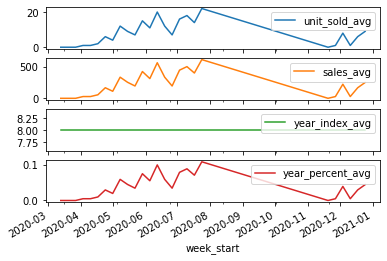

In [11]:
# Use product 11 for decorative spike

cur = data_avg[10]
cur.plot(legend=True,subplots=True)
cur.head()

In [12]:
# cur = cur.reset_index()
print(cur.info())
# cur.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26 entries, 2020-03-13 to 2020-12-25
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   unit_sold_avg     26 non-null     float64
 1   sales_avg         26 non-null     float64
 2   year_index_avg    26 non-null     float64
 3   year_percent_avg  26 non-null     float64
 4   asin_avg          26 non-null     object 
dtypes: float64(4), object(1)
memory usage: 1.2+ KB
None


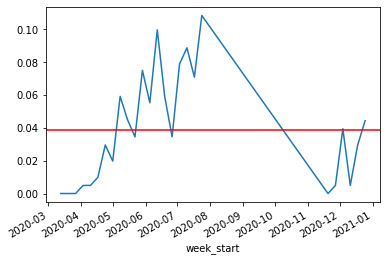

0.038461538461538464

In [14]:
from scipy.signal import find_peaks, peak_widths

plotable = cur['year_percent_avg']
plotable.plot(x='week_start')
avg = plotable.mean()
plt.axhline(y = avg, color = 'r', label = 'mean')
plt.show()
avg

In [ ]:
# Visualization
first_product = time_data.loc[time_data['asin'] == 'B01LXOVLEQ']

for i in range(3,10):
  # print(first_product['year_index'])
  year_data = first_product.loc[first_product['year_index'] == i]
  print(year_enum[i])
  # print(year_data)
  x = year_data['week_start'].to_numpy()
  y = year_data['unit_sold'].to_numpy()
  plt.plot(x,y)
  plt.show()
  plt.clf()
first_product.head()

In [ ]:
c = 0
distribution = [0] * 350
for id in unique_ids:
  cur_data = time_data.loc[time_data['asin'] == id]
  distribution[len(cur_data)] += 1

distribution

In [ ]:
plt.hist(distribution, color = 'blue', edgecolor = 'black',
         bins = 350)